# Read HDF File

In [1]:
import unittest
import os
import sys
import numpy
import datetime
import h5py
# import pyproj
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
plt.rcParams['animation.html'] = 'html5'

In [7]:
hdf_path = os.path.realpath('./model/')

In [8]:
os.listdir(hdf_path)

['Chippewa_2D.b02',
 'Chippewa_2D.bco02',
 'Chippewa_2D.c01',
 'Chippewa_2D.dss',
 'Chippewa_2D.g01',
 'Chippewa_2D.g01.hdf',
 'Chippewa_2D.IC.O02',
 'Chippewa_2D.p02',
 'Chippewa_2D.p02.hdf',
 'Chippewa_2D.prj',
 'Chippewa_2D.rasmap',
 'Chippewa_2D.rasmap.backup',
 'Chippewa_2D.s01',
 'Chippewa_2D.sed02',
 'Chippewa_2D.SedHeadXS02',
 'Chippewa_2D.SedLY01',
 'Chippewa_2D.SedLY_TEXT01',
 'Chippewa_2D.SedXS02',
 'Chippewa_2D.u04',
 'Chippewa_2D.u04.hdf',
 'Chippewa_2D.x01',
 'Mannings_n.hdf',
 'Mannings_n.tif',
 'Sediment Materials.hdf']

In [9]:
# explore hdf structure 
ras_file_path = os.path.join(hdf_path, "Chippewa_2D.p02.hdf")
geo_file_path = os.path.join(hdf_path, "Chippewa_2D.g01.hdf")

import h5py
with h5py.File(ras_file_path, 'r') as infile:
    # list all groups
    print("All Keys: %s" % list(infile.keys()))
    for k in infile.keys():
        print("Sub-Groups for %s: %s" % (k, list(infile[k].keys())))


All Keys: ['DSS Time Series', 'Event Conditions', 'Geometry', 'Plan Data', 'Results', 'Sediment', 'Unsteady Time Series']
Sub-Groups for DSS Time Series: ['2D Flow Areas', 'Boundary Conditions', 'Time', 'Time Date Stamp', 'Time Date Stamp (ms)', 'Time Step']
Sub-Groups for Event Conditions: ['Sediment', 'Unsteady']
Sub-Groups for Geometry: ['2D Flow Areas', 'AutoUpdateParameters', 'Boundary Condition Lines', 'Compute Processes', 'Cross Sections', 'GeomPreprocess', "Land Cover (Manning's n)", 'Structures']
Sub-Groups for Plan Data: ['Plan Information', 'Plan Parameters', 'Sediment']
Sub-Groups for Results: ['Summary', 'Unsteady']
Sub-Groups for Sediment: ['Bed Gradation Data', 'Boundary Conditions', 'Grain Class Data', 'Options', 'Sediment Control Volume']
Sub-Groups for Unsteady Time Series: ['2D Flow Areas', 'Boundary Conditions', 'Time', 'Time Date Stamp', 'Time Date Stamp (ms)', 'Time Step']


Note that there can be multiple flow areas. For now, the number of flow areas will be limited to one. However, future considerations of multiple flow areas include:
* connect with 1d model [limitation]
* connect across 
* others?

The 2D Flow Area Name is stored in the "Attributes" key of the HDF output file, and then there's another key named after the 2D Flow Area Name with all relevant geometry info. We will want to write code that will identify name of single flow area and use that information to retrieve the geometry. 

Main level keys:
* `DDS Time Series`
* `Event Conditions`
* `Geometry`
* `Plan Data`
* `Results`
* `Sediment`
* `Unsteady Time Series`

## Explore Geometry for 2D Flow Areas 
`geometry`
* `2D Flow Areas`:
    * `Cell Points`: northings and eastings of cell points (one for each cell)
    * `Cell Info`: min and max cell value  
    * `Attributes`: default values for 2d flow area generation. The first element of this array is the name of the 2D Flow Area. 
    * `Perimeter 1` (or other name -- whatever the 2D Flow Area is named): contains more keys to access additional geometry information. 
    * `Polygon Info`: what polygon points the 2D Flow area starts and ends with -- may need to explore further. 
    * `Polygon Parts`: Number of polygon points on the perimeter for every 2D Flow Area 
    * `Polygon Points`: Northings and eastings of the points along the perimeter of the boundary

In [16]:
# explore first level 2d flow area geometry keys:

with h5py.File(ras_file_path, 'r') as infile:
    # list all groups
    # print(infile['Geometry/2D Flow Areas/Cell Points'][()]) # northings and eastings 
    # print(infile['Geometry/2D Flow Areas/Cell Info'][()]) # number of cells
    # print(infile['Geometry/2D Flow Areas/Attributes'][()]) # default values for the 2d flow area generation 

    
    # print(infile['Geometry/2D Flow Areas/Perimeter 1'].keys()) # geometry info for perimeter 1 2d flow area 

    # print(infile['Geometry/2D Flow Areas/Polygon Info'][()]) # what polygon points it starts and ends with
    # print(infile['Geometry/2D Flow Areas/Polygon Parts'][()]) # number of polygon points on the perimeter for every 2d flow area 
    # print(infile['Geometry/2D Flow Areas/Polygon Points'][()].shape) # northings and eastings of the points along the perimeter of the boundary


    print(infile['Geometry/2D Flow Areas/Attributes'][()][0][0].decode('UTF-8'))

Perimeter 1


Notation Notes
* $c_r$ is the number of actual cells: here, 356 
* $c_p$ is the number of boundary cells/pseudo cells: here, 79 ?
* $c$ is the total number of cell: here, 435 ($c_r + c_p$)
* $m$ is the maximum number of facepoints making up a cell: here, 6
* $p$ is the number of facepoints: here, 433
* $f$ is the number of faces: here, 788

Cells:
* `Cells Center Coordinate`: Northings and Eastings 
    * $c$ x 2 
* `Cells Center Manning's n`
    * $c$ x 1
* `Cells Face and Orientation Info`
    * $c$ x 2 
    * first position: ranges from (0, 1575) 
    * second position: ranges from (1, $m$) -- max number of facepoints in a cell?

* `Cells Facepoint Indexes`
    * $c$ x $m$ array 
    * values are the facepoint values that make up the cell boundary
    * -1 for no data: fewer facepoints than the max number in the whole 2D area.
    * 2 positions have values for all cells > $c_r$ because just making the edge for a pseudo cell. 
* `Cells Minimum Elevation`
    * $c$ x 1 
* `Cells Surface Area`
    * $c$ x 1 
* `Cells Volume Elevation Info`
    * $c$ x 2 
    * first position ranges from (0,6063)
    * second position ranges from (0, 48)
* `Cells Volume Elevation Values`

Facepoints:
* `Facepoints Cell Index Values`: matches each FacePoint to a cell? **DON'T UNDERSTAND THE NUMBER**
    * 1655 x 1
    * Values range from (0, 434) -- $c$ - 1 (zero indexed)
* `FacePoints Cell Info`: ??
    * 433 x 2
    * first position ranges from (0, 1652)
    * second position ranges from (3, 5)
* `FacePoints Coordinate`: Northings and Eastings
    * 433 x 2 
* `FacePoints Face and Orientation Info`
    * 433 x 2 
    * first position ranges from (0, 1574)
    * second position ranges from (2, 5)
* `FacePoints Face and Orientation Values` **DON'T UNDERSTAND THE NUMBER**
    * 1576 x 2
    * first position (0, 787)
    * second position (-1, 1)
* `FacePoints Is Perimeter`
    * 433 x 1 
    * values are -1 or 0 

Faces:
* `Faces Area Elevation Info`
    * 788 x 2 
* `Faces Area Elevation Values` **DON'T UNDERSTAND THE NUMBER**
    * 5059 x 4
* `Faces Cell Indexes`
    * 788 x 2 
    * first value ranges from (0, 354) $c_r$ -1 
        * Is this the "start" cell?
    * second value ranges from (0, 434) - $c$ - 1 
        * Is this the "end" cell? 
        * If it flows to a pseudo cell, then flowing OUT of the mesh.
* `Faces Facepoint Indexes`
    * 788 x 2 
    * first value ranges from (0, 432)
    * second value ranges from (0, 432)
* `Faces Low Elevation Centroid`
* `Faces Minimum Elevation`
* `Faces NormalUnitVector and Length`
* `Faces Perimeter Info`
* `Faces Perimeter Values`
* `Perimeter`
* `Sediment Bed Material`



In [15]:
# dig into 2d flow area [Perimeter 1] 
with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/Perimeter 1/'].keys())
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/'].keys())
    ############### CELLS #####################################################################
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/Cells Center Coordinate'][()])
    # print(infile["Geometry/2D Flow Areas/Perimeter 1/Cells Center Manning's n"][()].shape)
    # print(max([f[1] for f in infile["Geometry/2D Flow Areas/Perimeter 1/Cells Face and Orientation Info"][()]]))
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes'][()][356:]) 
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/Cells Minimum Elevation'][()].shape) 
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/Cells Surface Area'][()].shape) 
    # print(max([f[1] for f in infile['Geometry/2D Flow Areas/Perimeter 1/Cells Volume Elevation Info'][()]])) 
    # print(min(infile['Geometry/2D Flow Areas/Perimeter 1/FacePoints Cell Index Values'][()])) 
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/Cells Surface Area'][()].shape) 

    ################### FACEPOINTS #############################################################
    # print(max([f[1] for f in infile['Geometry/2D Flow Areas/Perimeter 1/FacePoints Cell Info'][()]])) 
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate'][()]) 
    # print(max([f[1] for f in infile['Geometry/2D Flow Areas/Perimeter 1/FacePoints Face and Orientation Info'][()]])) 
    # print(max([f[0] for f in infile['Geometry/2D Flow Areas/Perimeter 1/FacePoints Face and Orientation Values'][()]])) 
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/FacePoints Face and Orientation Values'][()]) 
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/FacePoints Is Perimeter'][()].shape) 

    #################### FACES ###########################################################
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/Faces Area Elevation Info'][()].shape) 
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/Faces Area Elevation Values'][()].shape) 
    # print(min([f[1] for f in infile['Geometry/2D Flow Areas/Perimeter 1/Faces Cell Indexes'][()]])) 
    # print(min([f[1] for f in infile['Geometry/2D Flow Areas/Perimeter 1/Faces FacePoint Indexes'][()]])) 
    # print(infile['Geometry/2D Flow Areas/Perimeter 1/Faces FacePoint Indexes'][()]) 
    print(infile['Geometry/2D Flow Areas/Perimeter 1/Faces NormalUnitVector and Length'][()][:,2]) 




    # print(infile['Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate'][()].shape) # northings and eastings of a facepoint



    #self.geometry['faces_cell_indexes'] = infile['Geometry/2D Flow Areas/2D Interior Area/Faces Cell Indexes'][()]
    # self.geometry['cells_surface_area'] = infile['Geometry/2D Flow Areas/2D Interior Area/Cells Surface Area'][()]
    # self.geometry['faces_normal_unit_vector_and_length'] = infile['Geometry/2D Flow Areas/2D Interior Area/Faces NormalUnitVector and Length'][()]
    # self.geometry['cells_center_coordinate'] = infile['Geometry/2D Flow Areas/2D Interior Area/Cells Center Coordinate'][()]
    # faces_area_elevation_values = infile['Geometry/2D Flow Areas/2D Interior Area/Faces Area Elevation Values'][()]

    #self.geometry['face_length'] = self.geometry['faces_normal_unit_vector_and_length'][:,2]


<KeysViewHDF5 ['Boundary Conditions', 'Face Velocity', 'Log Hydraulics', 'Time Step', 'Water Surface']>
[396.04105  190.34332  274.1631   190.17271  140.36095  228.07346
 396.563    185.37605  234.07625  188.71815  210.91814  193.69731
 168.11853  190.04433  166.45038  161.04118  187.09326  173.88037
 168.21417  188.16167  162.08055  187.86644  198.27412  177.61464
 189.32039  199.54259  195.10329  180.52954  186.53804  209.52008
 174.69524  212.7367   146.38344  209.16638  143.31389  185.67015
 208.91365  149.56662  213.70403   94.7883   204.36354  253.60501
  96.96086  199.78383  286.38837  344.63272  153.18445  182.89415
 251.76665  405.04086   97.53615  205.72838   94.53212  203.64989
 188.51726  100.70706  207.68802  165.52376  218.6575   168.66534
 204.6544   190.15535  160.54916  186.61353  202.28099  189.82863
 178.3808   201.49173  179.92699  165.38507  134.66267  129.36743
  93.76235  153.83192  200.34483  166.38867  200.92462  174.92055
 199.34131  209.97566  186.91425  117.

### Voronoi Plotting

In [6]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np

In [7]:
import matplotlib.pyplot as plt
rng = np.random.default_rng()
points = rng.random((10,2))
print(points)

[[0.94039396 0.84077019]
 [0.36705205 0.27727313]
 [0.9224136  0.50228849]
 [0.39892901 0.73394417]
 [0.87781997 0.10043824]
 [0.03258967 0.05476883]
 [0.40830056 0.90829601]
 [0.68505152 0.91660376]
 [0.91267033 0.75924481]
 [0.4678361  0.96821919]]


In [8]:
vor = Voronoi(points)
vor

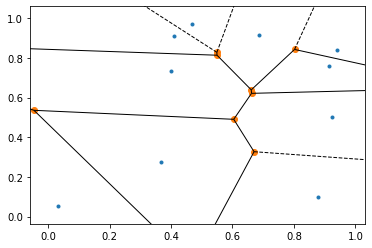

In [9]:
fig = voronoi_plot_2d(vor)

## Explore other areas

### Plan Data

#### Sediment

In [10]:
with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Plan Data'].keys())
    print(infile['Plan Data']['Sediment']['Output Parameters']['Custom Variables'][()])

<KeysViewHDF5 ['Plan Information', 'Plan Parameters', 'Sediment']>
[b'2D Cell Manning Total' b'2D Cell Manning Grain'
 b'2D Cell Settling Velocity (by GC)'
 b'2D Cell Critical Shear Stress (by GC)' b'2D Cell d50 Active'
 b'2D Cell d10 Active' b'2D Cell d90 Active'
 b'2D Cell Total-load Concentration (by GC)'
 b'2D Cell Total-load Conc Capacity (by GC)']


In [11]:
with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Plan Data']['Sediment']['Sediment Run Parameters'].keys())

<KeysViewHDF5 []>


#### Plan Parameters

In [12]:
with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Plan Data']['Plan Parameters'])

<HDF5 group "/Plan Data/Plan Parameters" (0 members)>


#### Plan Information

In [13]:
with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Plan Data']['Plan Information'].keys())

<KeysViewHDF5 ['Debug Commands']>


### Sediment

In [14]:
with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Sediment'].keys())

<KeysViewHDF5 ['Bed Gradation Data', 'Boundary Conditions', 'Grain Class Data', 'Options', 'Sediment Control Volume']>


In [15]:
with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Sediment']['Grain Class Data'].keys())

<KeysViewHDF5 ['Cohesive Classes', 'Density Data', 'Grain Class Bounds', 'Grain Class Names', 'Settling Depth']>


In [16]:
###


with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Face Velocity'][()].shape)
    print(infile['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Face Velocity'][()])

(1633, 788)
[[-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00  0.0000000e+00]
 [-0.0000000e+00 -0.0000000e+00 -0.0000000e+00 ... -0.0000000e+00
  -0.0000000e+00  0.0000000e+00]
 ...
 [-7.3885353e-04  6.8620387e-03 -4.5182803e-04 ... -0.0000000e+00
   1.7372467e-07  0.0000000e+00]
 [-7.3574705e-04  6.8466631e-03 -4.4891675e-04 ... -0.0000000e+00
   1.7344526e-07  0.0000000e+00]
 [-7.3266670e-04  6.8313414e-03 -4.4601416e-04 ... -0.0000000e+00
   1.7316606e-07  0.0000000e+00]]


In [ ]:


with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Face Velocity'][()].shape)
    print(infile['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Face Velocity'][()])

In [17]:
# computational interval: every 2 minutes 
# why is the first timestep different?
with h5py.File(ras_file_path, 'r') as infile:
    print(infile['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Time Step'][()])

[ 36. 120. 120. ... 120. 120. 120.]


In [14]:
with h5py.File(ras_file_path, 'r') as infile:   
    print(infile['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/Perimeter 1'].keys())
    print(infile['Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/Perimeter 1/Boundary Conditions'].keys())

<KeysViewHDF5 ['Boundary Conditions', 'Face Velocity', 'Log Hydraulics', 'Time Step', 'Water Surface']>
<KeysViewHDF5 ['Downstream', 'Downstream - Flow per Cell', 'Downstream - Stage per Cell', 'Upstream', 'Upstream - Flow per Cell', 'Upstream - Stage per Cell']>


In [18]:

with h5py.File(ras_file_path, 'r') as infile:
    # time in days maybe for boundary condition input files maybe
    print(infile['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['Time'][()])

[-0.00000000e+00  2.08333333e-02  4.16666667e-02 ...  3.39583333e+01
  3.39791667e+01  3.40000000e+01]
<KeysViewHDF5 ['2D Flow Areas', 'Boundary Conditions', 'Time', 'Time Date Stamp', 'Time Date Stamp (ms)', 'Time Step']>


## Results
### Timeseries

1633 timesteps

In [19]:
# look in results
with h5py.File(ras_file_path, 'r') as f:
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series'].keys())
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1'].keys())
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Log Hydraulics'][()].shape)
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Face Velocity'][()].shape)
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Water Surface'][()].shape)
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Time Step'][()].shape)


<KeysViewHDF5 ['2D Flow Areas', 'Boundary Conditions', 'Time', 'Time Date Stamp', 'Time Date Stamp (ms)', 'Time Step']>
<KeysViewHDF5 ['Boundary Conditions', 'Face Velocity', 'Log Hydraulics', 'Time Step', 'Water Surface']>
(1633, 10)
(1633, 788)
(1633, 435)
(1633,)


In [20]:
with h5py.File(ras_file_path, 'r') as f:
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Sediment']['Sediment Time Series']['Cross Sections'].keys())
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Sediment']['Sediment Time Series']['Cross Sections']['Shear Stress'][()])

    print(f['Results']['Unsteady']['Output']['Output Blocks']['Sediment']['Sediment Time Series']['Time'].shape)

<KeysViewHDF5 ['Effective Depth', 'Effective Width', 'Flow', 'Froude Number Channel', 'Invert Change', 'Invert Elevation', 'Long. Cum Vol Change', "Manning's n Channel", 'Mass Retention', 'Shear Stress', 'Velocity', 'Vol Bed Change Cum', 'Vol In Cum', 'Vol Out Cum', 'Water Surface', 'd10 Active', 'd10 Inactive', 'd50 Active', 'd50 Inactive', 'd90 Active', 'd90 Inactive']>
[[0. 0.]]
(35,)


In [21]:
with h5py.File(ras_file_path, 'r') as f:
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Time Step'][()].shape)

(1633,)


In [17]:
with h5py.File(ras_file_path, 'r') as f:
    print(f['Results']['Unsteady']['Output']['Output Blocks']['Base Output']['Unsteady Time Series']['2D Flow Areas']['Perimeter 1']['Time Step'][()])

[ 36. 120. 120. ... 120. 120. 120.]


In [22]:
''' Import RAS2D '''
sys.path.insert(0, src_path)
import RAS2D

module_path = C:\Users\sjordan\Documents\GitHub\ClearWater\modules\python\src
ClearWater repo path: C:\Users\sjordan\Documents\GitHub\ClearWater
TSM source path: C:\Users\sjordan\Documents\GitHub\ClearWater\modules\python\src\TSM


In [23]:
#open HEC-RAS 2D ouptut file 
ras_file_path = os.path.join(hdf_path,  "Chippewa_2D.p02.hdf")
ras2d_data = RAS2D.RAS_HDF5(ras_file_path, variables=[])
ras2d_data.read()

KeyError: 'Unable to open object (component not found)'

Elements Array:
Shape: (5765, 7)
Range: -1,5773 


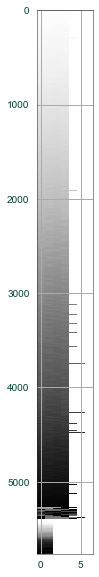

Nodes Array:
Shape:(5774, 2)
Range:404980.6574222861,1805021.8526864778

Faces Cell Indexes:
Shape:(11164, 2)
Range:0,5764

Cells Surface Area:
Shape:(5765,)
Range:-2.2737367544323206e-13,4726.1103515625

Faces Normal Unit Vector and Length:
Shape:(11164, 3)
Range:-1.0,93.10488891601562

Face Length:
Shape:(11164,)
Range:3.1000120639801025,93.10488891601562


In [ ]:
print(f"Elements Array:\nShape: {ras2d_data.geometry['elements_array'].shape}\nRange: {ras2d_data.geometry['elements_array'].min()},{ras2d_data.geometry['elements_array'].max()} ")

plt.figure(figsize = (1,10))
plt.imshow(ras2d_data.geometry['elements_array'], interpolation='nearest', aspect='auto')
plt.show()

print(f"Nodes Array:\nShape:{ras2d_data.geometry['nodes_array'].shape}\nRange:{ras2d_data.geometry['nodes_array'].min()},{ras2d_data.geometry['nodes_array'].max()}")
print(f"\nFaces Cell Indexes:\nShape:{ras2d_data.geometry['faces_cell_indexes'].shape}\nRange:{ras2d_data.geometry['faces_cell_indexes'].min()},{ras2d_data.geometry['faces_cell_indexes'].max()}")

print(f"\nCells Surface Area:\nShape:{ras2d_data.geometry['cells_surface_area'].shape}\nRange:{ras2d_data.geometry['cells_surface_area'].min()},{ras2d_data.geometry['cells_surface_area'].max()}")
print(f"\nFaces Normal Unit Vector and Length:\nShape:{ras2d_data.geometry['faces_normal_unit_vector_and_length'].shape}\nRange:{ras2d_data.geometry['faces_normal_unit_vector_and_length'].min()},{ras2d_data.geometry['faces_normal_unit_vector_and_length'].max()}")
print(f"\nFace Length:\nShape:{ras2d_data.geometry['face_length'].shape}\nRange:{ras2d_data.geometry['face_length'].min()},{ras2d_data.geometry['face_length'].max()}")

In [ ]:
ras2d_data.geometry['elements_array'][0:10]

ras2d_data.geometry['']

In [13]:
# set up information 
# from holoviews import opts
# n_verts = len(ras2d_data.geometry['nodes_array'])

# # define edges for Trimesh
# pts = [(x,z) for x,z in zip(ds_zarr.node_x.values, ds_zarr.node_z.values)] # pairs of nodes 
# tris = Delaunay(pts)

# x =ds_zarr.node_x.values
# y = ds_zarr.node_z.values
# r = ds_zarr['Liquid Saturation'][:,100] # pH at time = 200 

# # Format nodes for trimesh, including third dimension to plot (r, which represents pH here)
# nodes = np.column_stack([x, y, r])
# nodes = hv.Points(nodes, vdims='r')


# r = ds_zarr['Liquid Saturation'][:,100] # time = 300 

# # Format nodes for trimesh, including third dimension to plot (r, which represents pH here)
# nodes = np.column_stack([x, y, r])
# nodes = hv.Points(nodes, vdims='r')

# trimesh = hv.TriMesh((tris.simplices, nodes)).options( edge_color='r',
#                                                       colorbar=True,
#                                                       filled=True,
#                                                       inspection_policy='nodes',
#                                                       node_size=0, edge_line_width=0.1,
#                                                       height=400,
#                                                       width=1000,
#                                                       cmap="RdBu_r",
# #                                                       clim = (0,1),
#                                                       # ,colorbar=True
#                                                      )         


# trimesh_interp = rasterize(trimesh, aggregator=dsh.mean('r')).opts(colorbar=True,
#                                                                    cmap='RdBu_r',
#                                                                    width=1000,
#                                                                    height=400,
#                                                                    clim=(0,1),
#                                                                    clabel=ds_zarr['Liquid Saturation'].long_name)
# trimesh_interp

Keys: <KeysViewHDF5 ['Event Conditions', 'Geometry', 'Plan Data', 'Results']>


In [8]:
ras2d_data.geometry

{'elements_array': array([[   0,    1,    2, ...,   -1,   -1,   -1],
        [   4,    5,    1, ...,   -1,   -1,   -1],
        [   5,    4,    6, ...,   -1,   -1,   -1],
        ...,
        [5771, 5575,   -1, ...,   -1,   -1,   -1],
        [5772, 5651,   -1, ...,   -1,   -1,   -1],
        [5773, 5688,   -1, ...,   -1,   -1,   -1]]),
 'nodes_array': array([[ 406025.        , 1804975.        ],
        [ 406025.        , 1805015.23726173],
        [ 405943.16231932, 1805006.83768068],
        ...,
        [ 411262.9642    , 1801320.046     ],
        [ 412236.6254192 , 1801203.5563888 ],
        [ 411636.0086    , 1801093.727     ]]),
 'faces_cell_indexes': array([[   1,    2],
        [   1, 5391],
        [   1,    0],
        ...,
        [5147, 5762],
        [5235, 5763],
        [5251, 5764]]),
 'cells_surface_area': array([2478.019 , 2094.556 , 2259.9414, ...,    0.    ,    0.    ,
           0.    ], dtype=float32),
 'faces_normal_unit_vector_and_length': array([[ 1.0000000e+

In [35]:
RAS2D.plot_ras2d(ras2d_data.geometry['elements_array'], ras2d_data.geometry['nodes_array'])

TypeError: plot_ras2d() missing 3 required positional arguments: 'variable', 'dates', and 'outfile_interp_path'